本次以英雄联盟对局胜负预测任务为基础，要求实现决策树算法相关细节，加深对算法的理解，并了解做机器学习任务的大致流程。

### 任务介绍
英雄联盟（League of Legends，LoL）是一个多人在线竞技游戏，由拳头游戏（Riot Games）公司出品。在游戏中，每位玩家控制一位有独特技能的英雄，红蓝两支队伍各有五位玩家进行对战，目标是摧毁对方的基地水晶。水晶有多座防御塔保护，通常需要先摧毁一些防御塔再摧毁水晶。玩家所控制的英雄起初非常弱，需要不断击杀小兵、野怪和对方英雄来获得金币、经验。经验可以提升英雄等级和技能等级，金币可以用来购买装备提升攻击、防御等属性。对战过程中一般没有己方单位在附近的地点是没有视野的，即无法看到对面单位，双方可以通过使用守卫来监视某个地点，洞察对面走向、制定战术。
本数据集来自[Kaggle](https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min)，包含了9879场钻一到大师段位的单双排对局，对局双方几乎是同一水平。每条数据是前10分钟的对局情况，每支队伍有19个特征，红蓝双方共38个特征。这些特征包括英雄击杀、死亡，金钱、经验、等级情况等等。一局游戏一般会持续30至40分钟，但是实际前10分钟的局面很大程度上影响了之后胜负的走向。作为最成功的电子竞技游戏之一，对局数据、选手数据的量化与研究具有重要意义，可以启发游戏将来的发展和改进。

### 导入工具包
pandas是数据分析和处理常用的工具包，非常适合处理行列表格数据。numpy是数学运算工具包，支持高效的矩阵、向量运算。sklearn是机器学习常用工具包，包括了一些已经实现好的简单模型和一些常用数据处理方法、评价指标等函数。

In [35]:
from collections import Counter
import pandas as pd # 数据处理
import numpy as np # 数学运算
from sklearn.model_selection import train_test_split, cross_validate # 划分数据集函数
from sklearn.metrics import accuracy_score # 准确率函数
from sklearn.metrics import classification_report
RANDOM_SEED = 2020 # 固定随机种子

### 读入数据
假设数据文件放在`./data/`目录下，标准的csv文件可以用pandas里的`read_csv()`函数直接读入。文件共有40列，38个特征（红蓝方各19），1个标签列（blueWins），和一个对局标号（gameId）。对局标号不是标签也不是特征，可以舍去。

In [37]:
csv_data = './data/high_diamond_ranked_10min.csv' # 数据路径
data_df = pd.read_csv(csv_data, sep=',') # 读入csv文件为pandas的DataFrame

###  数据概览
对于一个机器学习问题，在拿到任务和数据后，首先需要观察数据的情况，比如我们可以通过`.iloc[0]`取出数据的第一行并输出。不难看出每个特征都存成了float64浮点数，该对局蓝色方开局10分钟有小优势。同时也可以发现有些特征列是重复冗余的，比如blueGoldDiff表示蓝色队金币优势，redGoldDiff表示红色方金币优势，这两个特征是完全对称的互为相反数。blueCSPerMin是蓝色方每分钟击杀小兵数，它乘10就是10分钟所有小兵击杀数blueTotalMinionsKilled。在之后的特征处理过程中可以考虑去除这些冗余特征。
另外，pandas有非常方便的`describe()`函数，可以直接通过DataFrame进行调用，可以展示每一列数据的一些统计信息，对数据分布情况有大致了解，比如blueKills蓝色方击杀英雄数在前十分钟的平均数是6.14、方差为2.93，中位数是6，百分之五十以上的对局中该特征在4-8之间，等等。

In [38]:
# print(data_df.iloc[0]) # 输出第一行数据
data_df.describe() # 每列特征的简单统计信息
data_df.head(5)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


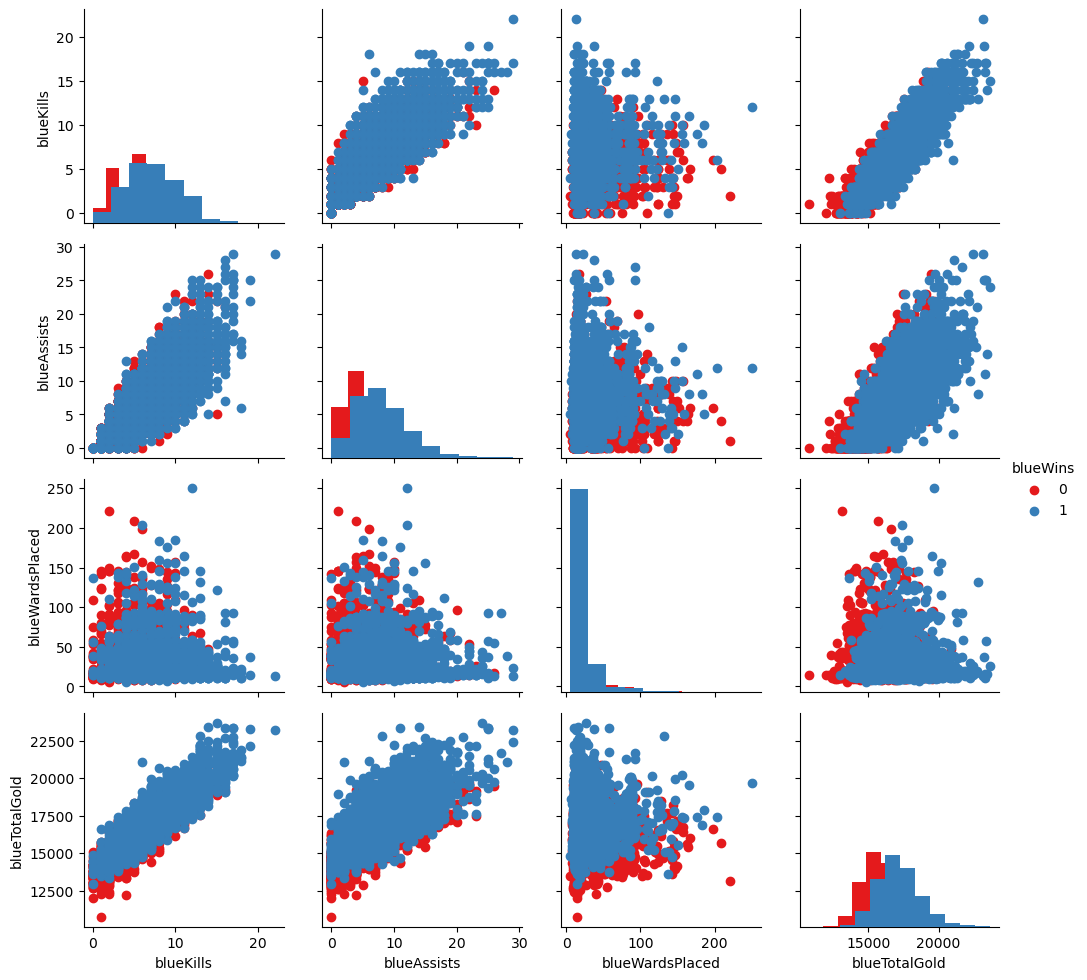

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.PairGrid(data=data_df, vars=['blueKills', 'blueAssists', 'blueWardsPlaced', 'blueTotalGold'], hue='blueWins', palette='Set1')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

### 增删特征
传统的机器学习模型大部分都是基于特征的，因此特征工程是机器学习中非常重要的一步。有时构造一个好的特征比改进一个模型带来的提升更大。这里简单展示一些特征处理的例子。首先，上面提到，特征列中有些特征信息是完全冗余的，会给模型带来不必要的计算量，可以去除。其次，相比于红蓝双方击杀、助攻的绝对值，可能双方击杀英雄的差值更能体现出当前对战的局势。因此，我们可以构造红蓝双方对应特征的差值。数据文件中已有的差值是金币差GoldDiff和经验差ExperienceDiff，实际上每个对应特征都可以构造这样的差值特征。

In [42]:
# drop_features = ['blueGoldDiff', 'redGoldDiff', 
#                  'blueExperienceDiff', 'redExperienceDiff', 
#                  'blueCSPerMin', 'redCSPerMin', 
#                  'blueGoldPerMin', 'redGoldPerMin'] # 需要舍去的特征列
# df = data_df.drop(columns=drop_features) # 舍去特征列


cols = ['gameId', 'redFirstBlood', 'redKills', 'redEliteMonsters', 'redDragons','redTotalMinionsKilled',
       'redTotalJungleMinionsKilled', 'redGoldDiff', 'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin', 'redHeralds',
       'blueGoldDiff', 'blueExperienceDiff', 'blueCSPerMin', 'blueGoldPerMin', 'blueTotalMinionsKilled']
df = data_df.drop(cols, axis=1)

info_names = [c[3:] for c in df.columns if c.startswith('red')] # 取出要作差值的特征名字（除去red前缀）
for info in info_names: # 对于每个特征名字
    df['br' + info] = df['blue' + info] - df['red' + info] # 构造一个新的特征，由蓝色特征减去红色特征，前缀为br
# 其中FirstBlood为首次击杀最多有一只队伍能获得，brFirstBlood=1为蓝，0为没有产生，-1为红
df.head(5)
df.describe()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redAvgLevel,redTotalExperience,brWardsPlaced,brWardsDestroyed,brDeaths,brAssists,brTowersDestroyed,brTotalGold,brAvgLevel,brTotalExperience
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,0.187974,...,6.925316,17961.730438,-0.079664,0.101731,-0.046260,-0.017006,0.008402,14.414111,-0.009313,-33.620306
std,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,0.390712,...,0.305311,1198.583912,25.960582,2.854910,4.195489,5.766787,0.324835,2453.349179,0.478434,1920.370438
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.800000,10465.000000,-260.000000,-23.000000,-16.000000,-25.000000,-2.000000,-10830.000000,-2.600000,-9333.000000
25%,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,...,6.800000,17209.500000,-4.000000,-1.000000,-3.000000,-4.000000,0.000000,-1585.500000,-0.400000,-1290.500000
50%,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,...,7.000000,17974.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,-28.000000
75%,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,...,7.200000,18764.500000,4.000000,1.000000,3.000000,4.000000,0.000000,1596.000000,0.200000,1212.000000
max,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,...,8.200000,22269.000000,234.000000,23.000000,17.000000,23.000000,4.000000,11467.000000,2.400000,8348.000000


In [43]:
discrete_df = df.copy() # 先复制一份数据

### 数据集准备
构建机器学习模型前要构建训练和测试的数据集。在本例中首先需要分开标签和特征，标签是不能作为模型的输入特征的，就好比作业和试卷答案不能在做题和考试前就告诉学生。测试一个模型在一个任务上的效果至少需要训练集和测试集，训练集用来训练模型的参数，好比学生做作业获得知识，测试集用来测试模型效果，好比期末考试考察学生学习情况。测试集的样本不应该出现在训练集中，否则会造成模型效果估计偏高，好比考试时出的题如果是作业题中出现过的，会造成考试分数不能准确衡量学生的学习情况，估计值偏高。划分训练集和测试集有多种方法，下面首先介绍的是随机取一部分如20%作测试集，剩下作训练集。sklearn提供了相关工具函数`train_test_split`。sklearn的输入输出一般为numpy的array矩阵，需要先将pandas的DataFrame取出为numpy的array矩阵。

In [44]:
all_y = discrete_df['blueWins'].values # 所有标签数据
feature_names = discrete_df.columns[1:] # 所有特征的名称
all_x = discrete_df[feature_names].values # 所有原始特征值，pandas的DataFrame.values取出为numpy的array矩阵

# 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)
all_y.shape, all_x.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape # 输出数据行列信息

((9879,), (9879, 30), (7903, 30), (1976, 30), (7903,), (1976,))

In [51]:
#SVC: Supprt Vector Classifier支持向量分类器
from sklearn.svm import SVC
#定义模型
model = SVC(C=1000, kernel='linear', degree=3, gamma='auto', 
					coef0=0.0, shrinking=True, probability=False, tol=0.001, 
					cache_size=200, class_weight=None, verbose=False, max_iter=-1, 
					decision_function_shape='ovr', random_state=None)


#训练模型
model.fit(x_train, y_train)



SVC(C=1000, gamma='auto', kernel='linear')

In [52]:
pred = model.predict(x_test)
pred, y_test
test_acc = accuracy_score(pred, y_test) # 将测试预测值与测试集标签对比获得准确率
print('accuracy: {:.4f}'.format(test_acc)) # 输出准确率
print(classification_report(pred, y_test))

accuracy: 0.7252
              precision    recall  f1-score   support

           0       0.75      0.70      0.73      1026
           1       0.70      0.75      0.72       950

    accuracy                           0.73      1976
   macro avg       0.73      0.73      0.73      1976
weighted avg       0.73      0.73      0.73      1976



### 总结
一个完整的机器学习任务包括：确定任务、数据分析、特征工程、数据集划分、模型设计、模型训练和效果测试、结果分析和调优等多个阶段，本案例以英雄联盟游戏胜负预测任务为例，给出了每个阶段的一些简单例子，帮助大家入门机器学习，希望大家有所收获！